# 1. Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import json
import logging
import os
from datetime import datetime
from pathlib import Path

import pandas as pd
import regex as re
import typer
from dateutils import relativedelta
from unidecode import unidecode

from analysis.config import *
from analysis.preprocessing import map_progress, tokenizer_lemma
from analysis.utils import *
from src.custom_logger import get_logger

# Removendo aviso de debug
os.environ["PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT"] = "3000"
# Removendo limitação de print de dfs
# pd.set_option("display.max_rows", 500)
# pd.set_option("display.max_columns", 500)
# pd.set_option("display.width", 1000)

# Caminho da pasta contendo os csvs
data_path = "data/2023/01/19/"
places_file = "data/places.csv"
input_file = "input/hotels_23_01_19.csv"
reports_folder = Path("./reports")
Path(reports_folder).mkdir(exist_ok=True)
data_folder = Path("./data/prep")
Path(data_folder).mkdir(exist_ok=True)


In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
from itertools import chain

join_str = lambda x: "\n".join(list(x)) if x is not None else ""
join_list = lambda x: list(chain.from_iterable(x))

# 2. Stats

```
Hotéis         50
Avaliações 150774
Sentenças  329235
Tokens    1633318
```

In [6]:
df_prep = pd.read_parquet("data/prep/df_text_prep_2023-06-22_20-52-11_175568.pq")
df_hotels = pd.read_parquet("data/prep/df_hotels_2023-06-22_20-52-11_175568.pq")

In [22]:
n_hotels = df_prep.name.drop_duplicates().count()
n_hotels

50

In [16]:
df_prep["text_na"] = (df_prep.text == '') | (df_prep.text.isna())

In [23]:
n_reviews = (~df_prep["text_na"]).sum()
n_reviews

150774

In [31]:
n_sentences = df_prep[(~df_prep["text_na"])].text_tokens.apply(len).sum()
n_sentences

329235

In [28]:
n_tokens = df_prep.text_tokens.apply(join_list).apply(len).sum()
n_tokens

1633318

# 3. Corpus

In [151]:
import numpy as np

# Review level documents
text_tokens_flat = df_prep[(~df_prep["text_na"])].text_tokens.apply(join_list)
df_prep.loc[(~df_prep["text_na"]),"text_tokens_flat"] = text_tokens_flat

# Hotel level documents
# text_tokens_flat = df_hotels.text_tokens_sum.apply(join_list)

text_tokens_flat.shape

(150774,)

In [34]:
text_tokens_flat.head()

0    [bom, preco, otima, localizacao, atendimento, ...
1    [nunca, quarto, hotel, tao, sujo, vida, lencol...
2    [hotel, baixissima, qualidad, atendimento, aco...
3    [pessimo, atendimento, classico, rio, janeiro,...
6    [experiencia, nao, boa, ness, hotel, propagand...
Name: text_tokens, dtype: object

In [35]:
from gensim import corpora

corpus = text_tokens_flat.to_list()
gensim_dictionary = corpora.Dictionary(corpus)

text_tokens_corpus = text_tokens_flat.progress_apply(lambda x:gensim_dictionary.doc2bow(x, allow_update=False))
gensim_corpus = text_tokens_corpus.to_list()

100%|██████████| 150774/150774 [00:01<00:00, 107786.02it/s]


# 4. Topic Modeling

In [36]:
# Treinando modelo
import gensim
from gensim.models import CoherenceModel

hdp_model = gensim.models.hdpmodel.HdpModel(
    corpus=gensim_corpus, 
    id2word=gensim_dictionary, 
    T=30
)

In [38]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=gensim_corpus, 
    num_topics=10, 
    id2word=gensim_dictionary, 
    passes=10,
    # per_word_topics=True
)

In [39]:
def perplexity_score(model: gensim.models.ldamodel.LdaModel):
    return model.log_perplexity(gensim_corpus)

print('LDA Perplexity:', perplexity_score(lda_model))

LDA Perplexity: -7.826251888663526


In [40]:
def coherence_score(model, coherence='u_mass'):
    coherence_score_model = CoherenceModel(model=model, texts=corpus, dictionary=gensim_dictionary, coherence=coherence)
    return coherence_score_model.get_coherence()

print("u_mass")
print('LDA Coherence Score:', coherence_score(lda_model))
print('HDP Coherence Score:', coherence_score(hdp_model))

u_mass
LDA Coherence Score: -3.4015809945855375
HDP Coherence Score: -2.119564010808948


In [ ]:
# inspect the size of a python object in bytes
import joblib
joblib.dump(lda_model, "lda_model.joblib")
# 6mb

['lda_model.joblib']

In [50]:
def train_and_eval(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=gensim_corpus, 
        id2word=gensim_dictionary, 
        passes=4,
        # chunksize=100,
        # per_word_topics=True,
        num_topics=n, 
        alpha=alpha,
        eta=beta,
    )
    p = perplexity_score(lda_model)
    c = coherence_score(lda_model)
    return lda_model, {"n":n, "alpha":alpha, "beta":beta, "perplexity":p, "coherence":c}

In [196]:
import itertools
import pyperclip
import random
import joblib
#list containing various hyperparameters
grid = {
    "n":[6,8,10],
    # "n":[6,10,14,18,20],
    "alpha":['symmetric',0.3,0.7],
    "beta":['auto',0.3,0.7],
}


combinations_list = list(itertools.product(*grid.values()))
random.shuffle(combinations_list)
l = len(combinations_list)
print("len(combinations_list)", l)

# EARLY_STOP_CLIPBOARD_STRING

results = []
best_result = None
best_model = None
for i, params in tqdm(enumerate(combinations_list), total=l):
    model, result = train_and_eval(*params)
    results.append(result)
    if best_result is None or results[-1]["coherence"] > best_result["coherence"]:
        best_result = results[-1]
        best_model = model
        print("best_result", results[-1])
    try:
        if pyperclip.paste() == "STOP_CLIPBOARD_STRING":
            print("Early stop via clipboard!")
            break
    except:
        pass

joblib.dump(results, "results/results_2.joblib")
joblib.dump(best_model, "results/best_model_2.joblib")

len(combinations_list) 27


  4%|▎         | 1/27 [03:09<1:22:02, 189.33s/it]

best_result {'n': 8, 'alpha': 0.3, 'beta': 0.7, 'perplexity': -7.434020834992561, 'coherence': -3.2640468132661393}


 15%|█▍        | 4/27 [12:45<1:13:54, 192.81s/it]

best_result {'n': 8, 'alpha': 0.3, 'beta': 'auto', 'perplexity': -7.505636275806253, 'coherence': -3.1891454094606977}


 26%|██▌       | 7/27 [22:17<1:03:40, 191.02s/it]

best_result {'n': 6, 'alpha': 0.3, 'beta': 'auto', 'perplexity': -7.368665734611452, 'coherence': -2.870710258417413}


 30%|██▉       | 8/27 [24:54<57:04, 180.25s/it]  

best_result {'n': 6, 'alpha': 0.7, 'beta': 'auto', 'perplexity': -7.315673865818428, 'coherence': -2.859783464141598}


 59%|█████▉    | 16/27 [47:45<33:03, 180.35s/it]

best_result {'n': 6, 'alpha': 0.3, 'beta': 0.3, 'perplexity': -7.310489535673464, 'coherence': -2.821091207319128}


 67%|██████▋   | 18/27 [53:15<25:59, 173.32s/it]

best_result {'n': 6, 'alpha': 'symmetric', 'beta': 0.3, 'perplexity': -7.323800558753622, 'coherence': -2.73905342110209}


 85%|████████▌ | 23/27 [1:06:34<10:43, 160.94s/it]

best_result {'n': 6, 'alpha': 'symmetric', 'beta': 0.7, 'perplexity': -7.37209934903147, 'coherence': -2.7324706703524178}


100%|██████████| 27/27 [1:17:03<00:00, 171.25s/it]


['results/best_model_2.joblib']

# 5. Results

In [197]:
df_gs = pd.DataFrame(results)
df_gs.describe()

,n,perplexity,coherence
count,27.000000,27.000000,27.000000
mean,8.000000,-7.440300,-3.317573
std,1.664101,0.132119,0.552477
min,6.000000,-7.837722,-5.404594
25%,6.000000,-7.465038,-3.389848
50%,8.000000,-7.402925,-3.221300
75%,10.000000,-7.363143,-3.000412
max,10.000000,-7.304172,-2.732471


In [198]:
default_filter = (df_gs.alpha == "symmetric") & (df_gs.beta == "auto")
default_filter_neg = (df_gs.alpha != "symmetric") & (df_gs.beta != "auto")
# df_gs.loc[default_filter].plot.scatter(x="n", y=["coherence"])

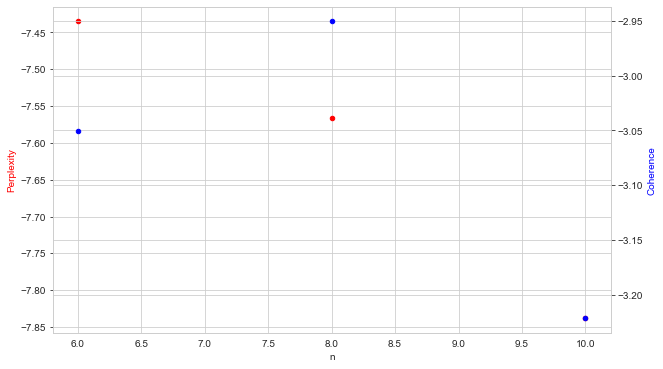

In [199]:
# plot coherence and perplexity
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

df_gs.loc[default_filter].plot.scatter(x="n", y=["perplexity"], ax=ax1, color="red")
df_gs.loc[default_filter].plot.scatter(x="n", y=["coherence"], ax=ax2, color="blue")

ax1.set_ylabel("Perplexity", color="red")
ax2.set_ylabel("Coherence", color="blue")

plt.show()


In [200]:
df_gs.sort_values("coherence", ascending=False).head(5)

,n,alpha,beta,perplexity,coherence
22,6,symmetric,0.7,-7.372099,-2.732471
17,6,symmetric,0.3,-7.323801,-2.739053
15,6,0.3,0.3,-7.310490,-2.821091
7,6,0.7,auto,-7.315674,-2.859783
6,6,0.3,auto,-7.368666,-2.870710


In [201]:
df_gs.sort_values("perplexity", ascending=False).head(5)

,n,alpha,beta,perplexity,coherence
24,6,0.7,0.3,-7.304172,-2.874166
15,6,0.3,0.3,-7.310490,-2.821091
7,6,0.7,auto,-7.315674,-2.859783
17,6,symmetric,0.3,-7.323801,-2.739053
18,6,0.7,0.7,-7.347805,-3.102064


c:\Users\Bruno\miniconda3\envs\pln\lib\site-packages\matplotlib\collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


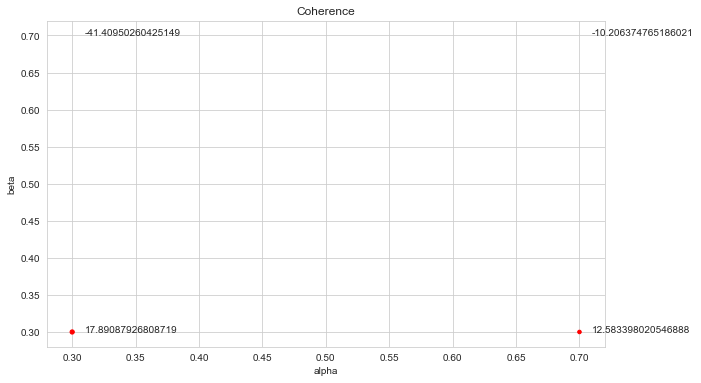

In [202]:
# plot alpha on the x axis, and beta on the y axis, with the size of the bubble determined by the coherence score, and the value annotated in the bubble
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

df_gs_float = df_gs.loc[default_filter_neg & (df_gs.n == 6)].copy()
df_gs_float.alpha = df_gs_float.alpha.astype(float)
df_gs_float.beta = df_gs_float.beta.astype(float)
df_gs_float.coherence = (df_gs_float.coherence +3)*100

df_gs_float.plot.scatter(x="alpha", y="beta", s=df_gs_float.coherence, ax=ax1, color="red")

for i, row in df_gs_float.iterrows():
    ax1.annotate(row["coherence"], (row["alpha"]+0.01, row["beta"]))
plt.title("Coherence")
plt.show()



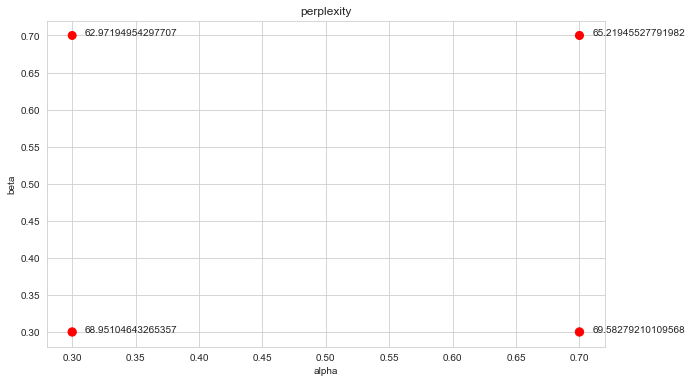

In [203]:
# plot alpha on the x axis, and beta on the y axis, with the size of the bubble determined by the coherence score, and the value annotated in the bubble
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

df_gs_float = df_gs.loc[default_filter_neg & (df_gs.n == 6)].copy()
df_gs_float.alpha = df_gs_float.alpha.astype(float)
df_gs_float.beta = df_gs_float.beta.astype(float)
df_gs_float.perplexity = (df_gs_float.perplexity +8)*100

df_gs_float.plot.scatter(x="alpha", y="beta", s=df_gs_float.perplexity, ax=ax1, color="red")

for i, row in df_gs_float.iterrows():
    ax1.annotate(row["perplexity"], (row["alpha"]+0.01, row["beta"]))
plt.title("perplexity")
plt.show()


# 6. Best Model

In [204]:
df_gs.sort_values("coherence", ascending=False).iloc[0]

n                     6
alpha         symmetric
beta                0.7
perplexity    -7.372099
coherence     -2.732471
Name: 22, dtype: object

In [205]:
# Treinando Modelo de melhor resultado
n = 6
alpha = "symmetric"
beta = 0.7

lda_model, results = train_and_eval(n, alpha, beta)

print("Results:\n", results)

Results:
 {'n': 6, 'alpha': 'symmetric', 'beta': 0.7, 'perplexity': -7.369366405974172, 'coherence': -2.890226121978887}


In [210]:
# Visualizando tópicos
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt


* função para sumarizar baseada em um ou mais hoteis:
    * Biblioteca para modelagem de texto em hotéis
    * revista grupo nature dados
    * Congresso - precisa ir apresentar.s Para aluno precisa requisitar com antecedência
    * Revista boa - JCR, fator de impacto, média de citações dos artigos da revista
    * pró reitor unifei amigo do alexandres
    * https://www.nature.com/sdata/
    * ver se a biblioteca não vai infringir a política do google
    * Teriamos que publicar os dados
    * Congresso é bom para fazer contatos
    * Reunião segunda

In [211]:
print("LDA visualization")
lda_visualization = gensimvis.prepare(lda_model, gensim_corpus, gensim_dictionary)
pyLDAvis.display(lda_visualization)

LDA visualization


c:\Users\Bruno\miniconda3\envs\pln\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [212]:
def print_topics_formatted(model, num_words=10):
    topics = model.print_topics(num_words=num_words)
    for i, topic in enumerate(topics):
        t_str = topic[1]
        t_str = re.sub(r"[^a-zA-Z]", " ", t_str)
        t_str = re.sub(r"\s+", " ", t_str)
        t_str = f"Tópico {i}: {t_str}"
        print(t_str)

def print_topics(model, num_words=10):
    topics = model.print_topics(num_words=num_words)
    for topic in topics:
        print(topic)

In [213]:
# Imprimindo tópicos encontrados
print("LDA topics")
print_topics_formatted(lda_model, num_words=20)

LDA topics
Tópico 0:  melhor otimo hotel espetacular vale pena princip copacabana porto rio resort luxo brasil custo beneficio fino janeiro hotei palac cidad 
Tópico 1:  nao hotel dia todo sempr funcionario bem ate voltar quero voce tudo recepcao aqui vez hosped experiencia ano desd pessoa 
Tópico 2:  nao piscina quarto sao hotel crianca cafe restaurant comida resort manha pouco praia bem ponto muita dia tambem agua porem 
Tópico 3:  bom hotel excelent boa cafe manha otima quarto atendimento bem funcionario comida praia limpo servico estrutura tudo piscina localizacao bonito 
Tópico 4:  equip paraben tia tio top show todo amei sensacion maravilhosa restaurant especi atendimento fantastico sao estrela toda recreacao atenciosa adorei 
Tópico 5:  lugar excelent maravilhoso atendimento lindo otimo super recomendo tudo perfeito incrivel hotel comida familia funcionario agradavel nota local experiencia todo 


In [214]:
lda_topics_chat_gpt = {
0:"Luxo e encanto no Rio de Janeiro: hotéis espetaculares em Copacabana e Porto",
1:"Experiência inesquecível: funcionários dedicados e hospitalidade excepcional",
2:"Relaxamento à beira da piscina: hotéis familiares com ótimo café da manhã e acesso à praia",
3:"Conforto e qualidade: hotéis com excelente atendimento, quartos bonitos e ótima localização",
4:"Entretenimento e diversão: shows especiais, atendimento estrelar e recreação fantástica",
5:"Maravilhas e encantos: locais excelentes com atendimento incrível, comida deliciosa e experiência memorável",
}

In [140]:
# Imprimindo tópicos encontrados
print("HDP topics")
print_topics_formatted(hdp_model)

HDP topics
Tópico 0:  nao hotel quarto bem bom piscina atendimento sao excelent cafe
Tópico 1:  bom hotel atendimento excelent nao quarto lugar otimo bem boa
Tópico 2:  hotel bom atendimento excelent nao lugar quarto otimo bem boa
Tópico 3:  bom hotel excelent atendimento nao lugar quarto otimo bem boa
Tópico 4:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 5:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 6:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 7:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 8:  bom excelent atendimento hotel lugar otimo nao quarto boa bem
Tópico 9:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 10:  bom excelent atendimento hotel lugar otimo nao quarto boa bem
Tópico 11:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 12:  bom excelent atendimento hotel lugar otimo nao quarto boa bem
Tópico 13:  bom excelent atendimento

In [215]:
# Definindo função para atribuir topicos ao documento
def get_topics(tokens, model=lda_model, topic_names:dict = {}, prefix="lda_"):
    doc_bow = gensim_dictionary.doc2bow(tokens)
    doc_topics_list = model[doc_bow]
    doc_topics = {str(topic_id):topic_prob for topic_id, topic_prob in doc_topics_list}
    doc_topics["first_topic"] = sorted(doc_topics_list, key=lambda x:x[1], reverse=1)[0][0]
    doc_topics["first_topic_name"] = topic_names.get(doc_topics["first_topic"], None)
    result = pd.Series(doc_topics)
    result = result.add_prefix(prefix)
    return result

get_topics(text_tokens_flat.iloc[2], model=lda_model, topic_names=lda_topics_chat_gpt)

lda_2                                                            0.760618
lda_3                                                            0.205741
lda_first_topic                                                         2
lda_first_topic_name    Relaxamento à beira da piscina: hotéis familia...
dtype: object

In [216]:
# df_prep.loc[(~df_prep["text_na"]),["lda_0","lda_1","lda_2","lda_3","lda_4","lda_5","lda_first_topic","lda_first_topic_name"]] = \
text_topics = \
    df_prep.loc[(~df_prep["text_na"]),["text_tokens_flat"]].progress_apply(
        lambda x: get_topics(x.text_tokens_flat, model=lda_model, topic_names=lda_topics_chat_gpt),
        axis=1,
        result_type="expand",
    ).fillna(0)

100%|██████████| 150774/150774 [02:49<00:00, 889.91it/s] 


In [217]:
df_prep.loc[(~df_prep["text_na"]),["lda_0","lda_1","lda_2","lda_3","lda_4","lda_5","lda_first_topic","lda_first_topic_name"]] = \
    text_topics

In [221]:
df_prep.loc[(~df_prep["text_na"]),["lda_0","lda_1","lda_2","lda_3","lda_4","lda_5","lda_first_topic","lda_first_topic_name"]].head()

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_first_topic,lda_first_topic_name
0,0.000000,0.000000,0.655126,0.321025,0.000000,0.000000,2.0,Relaxamento à beira da piscina: hotéis familia...
1,0.000000,0.385357,0.509696,0.000000,0.034067,0.061580,2.0,Relaxamento à beira da piscina: hotéis familia...
2,0.000000,0.000000,0.760576,0.205783,0.000000,0.000000,2.0,Relaxamento à beira da piscina: hotéis familia...
3,0.128979,0.248065,0.558441,0.000000,0.000000,0.053553,2.0,Relaxamento à beira da piscina: hotéis familia...
6,0.000000,0.478672,0.334847,0.161329,0.000000,0.000000,1.0,Experiência inesquecível: funcionários dedicad...


In [219]:
save_df(df_prep, "data/processed", "df_topics")

data/processed/df_topics_2023-07-09_23-48-54_286392.pq
